# 4. First model using logistic regression classifier

---
**To be able to execute this notebook, please download your own local version of the data from https://www.kaggle.com/martinellis/nhl-game-data and store it into the folder "data/nhl/nhl_stats/"**


---

After the data regarding player and game plays, especially for shots and goals, was explored, we can try to predict the probability of scoring a goal for each shot. The model should predict, whether or not a specific shot will score a goal. The outcome of the model should be 0 (not scoring a goal) or 1 (scoring a goal). In the first step, the prediction will use the location from which the shot of interest was made and the type of the shot.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import math
import time

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
from matplotlib import patches

from utils import create_dummy_df
from utils import plot_correlation_matrix

sns.set()

---
Loading the data for game plays:

In [2]:
df_game_plays = pd.read_csv('data/nhl/nhl_stats/game_plays.csv')
df_game_plays.head()

,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y
0,2016020045_1,2016020045,NaN,NaN,Game Scheduled,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-18 23:40:58,0,0,Game Scheduled,NaN,NaN
1,2016020045_2,2016020045,NaN,NaN,Period Ready,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:35:28,0,0,Period Ready,NaN,NaN
2,2016020045_3,2016020045,NaN,NaN,Period Start,NaN,NaN,NaN,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Period Start,NaN,NaN
3,2016020045_4,2016020045,16.0,4.0,Faceoff,NaN,0.0,0.0,1,REGULAR,0,1200.0,2016-10-19 01:40:50,0,0,Jonathan Toews faceoff won against Claude Giroux,0.0,0.0
4,2016020045_5,2016020045,16.0,4.0,Shot,Wrist Shot,-71.0,9.0,1,REGULAR,54,1146.0,2016-10-19 01:41:44,0,0,Artem Anisimov Wrist Shot saved by Michal Neuv...,71.0,-9.0


## Preparing data for the first model

In order to predict a binary outcome of the model, a classifier can be used. There are several different classifiers provided by different Python libraries. One of the most common classifiers is the [Logistic Regression classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) provided by [scikit-learn](https://scikit-learn.org/stable/) library. This model takes various variables as predictive features (predictors) and predicts the outcome value 0 or 1. More information regarding how Logistic Regression work can be found [here](https://en.wikipedia.org/wiki/Logistic_regression).

---

Before we use data for the logistic regression, some preparation steps need to be done. We need to select predictors, check and drop duplicates, check and drop NaN values. We also need to convert categorical columns to columns with numerical values.

#### Starting with location and type of the shot

---
Reading and dropping duplicates:

In [3]:
df = df_game_plays[['play_id', 'event', 'secondaryType', 'st_x', 'st_y']][(df_game_plays.event=='Goal') | (df_game_plays.event=='Shot')]
df.dropna(inplace=True)
df.secondaryType = df.secondaryType.str.replace(" ", "")
df.secondaryType = df.secondaryType.str.replace("-", "")

df.head()

,play_id,event,secondaryType,st_x,st_y
4,2016020045_5,Shot,WristShot,71.0,-9.0
5,2016020045_6,Goal,Wraparound,88.0,-5.0
7,2016020045_8,Shot,WristShot,56.0,-7.0
11,2016020045_12,Shot,SlapShot,37.0,24.0
16,2016020045_17,Shot,WristShot,57.0,-20.0


___
Converting categorical values of goal to 1 (goal) and 0 (no-goal). Checking NaN values:

In [4]:
df['goal'] = np.where(df.event=='Goal', 1, 0)
df.drop(columns='event', inplace=True)
df.isna().sum()

play_id          0
secondaryType    0
st_x             0
st_y             0
goal             0
dtype: int64

___
The final data preparation step is converting the type of the shot (*secondaryEvent*) to numerical columns.

In [5]:
cat_cols = ['secondaryType']
df_data = create_dummy_df(df=df, cat_cols=cat_cols, dummy_na=True)
df_data.drop(columns=['secondaryType_nan'], inplace=True)
df_data.head()

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
4,2016020045_5,71.0,-9.0,0,0,0,0,0,0,1
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0
7,2016020045_8,56.0,-7.0,0,0,0,0,0,0,1
11,2016020045_12,37.0,24.0,0,0,1,0,0,0,0
16,2016020045_17,57.0,-20.0,0,0,0,0,0,0,1


---
### Using data in the first version of the logistic regression model.

In [6]:
features = ['st_x', 'st_y', 'secondaryType_Deflected', 'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound', 'secondaryType_WristShot']

target = 'goal'

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.2f}')

Score of the model is 0.91


___
### Model evaluation.

The accuracy score of **0.91** looks really amazing. This means, that the model predicticted for 90% of situations (which are shots on goal) a correct outcome. However, simple score alone might be a pretty misleading metrics for testing classifier. It can hide several potential pitfalls. Much more sufficient way to evaluate a classifier is the **confusion matrix**. A confusion matrix provides information on how many positive (goal) and how many negative (no goal) predictions have been done successfully.

In order to understand confusion matrix, let's define some key terms: <br>

* **True Positive (TP)** - Predicted **goal** where there was **really a goal**. <br>
* **True Negative (TN)** - Predicted **no goal** where there was **no goal**. <br>
* **False Positive (FP)** (Type I error) - Predicted **goal** where there was **no goal**. <br>
* **False Negative (FN)** - Predicted **no goal** where there was **really a goal**.<br>

---

Then we can plot a confusion matrix displaying this terms in a matrix with two axes: <br>
* Predicted with bins 0 and 1, showing values predicted as 0 or 1.
* Real with bins 0 and 1, showing real values from the test part of the data set as 0 or 1.


Plotting confusion matrix for our logistic regression classifier:


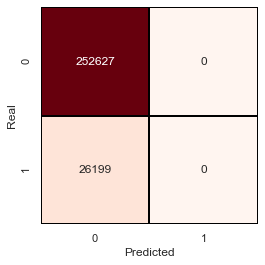

In [7]:
cmatrix = confusion_matrix(y_test, lr_model.predict(X_test))
sns.heatmap(cmatrix, annot=True,  fmt=".0f", linewidths=1, square = True, cmap='Reds', linecolor='black', cbar=False);
plt.ylabel('Real');
plt.xlabel('Predicted');

Using confusion matrix, we can calculate following metrics to evaluate the classifier:

$$ Precision = \frac{True Positive}{True Positive + False Positive} $$

$$ Recall = \frac{True Positive}{True Positive + False Negative} $$

---
With *Precision* and *Recall*, we can calculate F1 Score metrics used for overall evavualtion of the classifier:

$$ F1 Score = 2 * \frac{Recall * Precision}{Recall + Precision} $$ 

Value of F1 Score can be in interval [0, 1], where *0* is the worst and *1*  the best value. Further details on F1 Score can be found [here](https://en.wikipedia.org/wiki/F-score).

---
Having all metrics defines, we can evaluate the model again. Let's get the F1 Score of our model:

In [8]:
 print(f'F1 Score of the model is {f1_score(y_test, lr_model.predict(X_test))}')

F1 Score of the model is 0.0


And here we are. The F1 score of the model is *0*, which mean the model is not working at all.

___

What acually happened is that the regression model predicted all outcomes as *0*. Investigating the number of shots with no goal target vs. number of shots scoring goals in the test part of the dataset **y_test**, there is the explanation of why the score was that high (90.60%). We have 90.60% portion of no-goal situations in the test part of the dataset and predicting *0* for all of them gets the score of 90.60%:

In [9]:
y_test[y_test==0].count() / y_test.shape[0]

0.9060381743452907

**Two findings here:**
* Values of the *target* in the dataset are not balanced.
* Accuracy score is not enough to evaluate the performance of the model

Let's have a look at the data histograms and try to balance the data.

### Balancing dataset

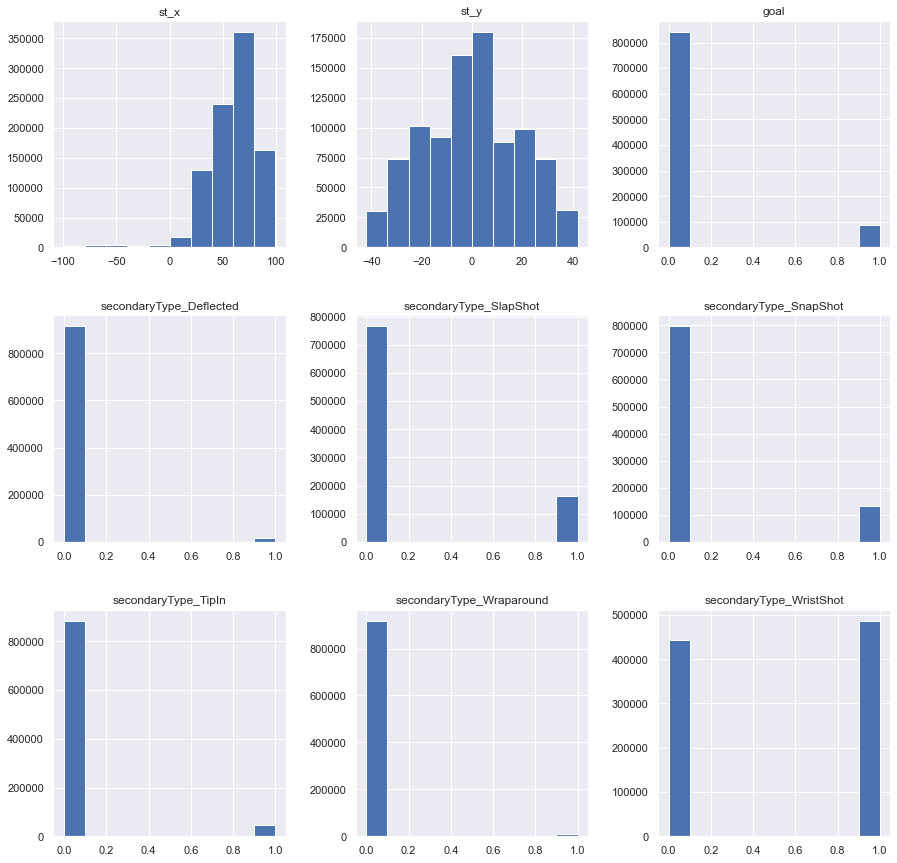

In [10]:
# checking data distribution of the predictive features
df_data.hist(figsize=(15, 15));

We can see the unbalanced portion of *0s* and *1s* in the target (*goal*) 

---
Let's select a subset of data using the same number of 0/1 in the target (*goal*):

In [11]:
# taking all goals and a sample with the same size from shot without a goal (under-sampling)
goals = df_data[df_data.goal==1]
no_goals = df_data[df_data.goal==0].sample(goals.shape[0], replace=False)
df_data = pd.concat([goals, no_goals])

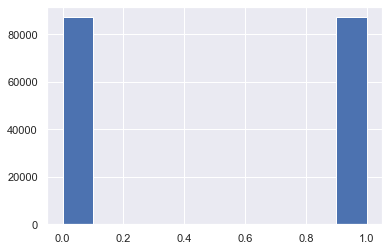

In [12]:
df_data.goal.hist();

This lools pretty balanced. Let's re-train the model again.
___
### Repeat training and evaluation:

In [13]:
features = ['st_x', 'st_y', 'secondaryType_Deflected', 'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound', 'secondaryType_WristShot']

target = 'goal'

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.4f}')

#f1 score
print(f'F1-Score of the model is {f1_score(y_test, lr_model.predict(X_test)):.4f}')

Score of the model is 0.6328
F1-Score of the model is 0.6579


___
And plot the confusion matrix:

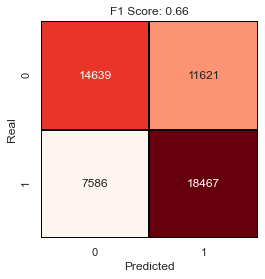

In [14]:
cmatrix = confusion_matrix(y_test, lr_model.predict(X_test))
sns.heatmap(cmatrix, annot=True,  fmt=".0f", linewidths=1, square = True, cmap='Reds', linecolor='black', cbar=False);
plt.ylabel('Real');
plt.xlabel('Predicted');
plt.title(f'F1 Score: {f1_score(y_test, lr_model.predict(X_test)):.2f}');

All right, this is actually a quite diffferent situation! The model started to predict both, positive and negative values. The score and the F1 score went down although. In order to improve the F1-Score, several actions can be taken. These can be for example:

* Modelling/using of new predictive features.
* Using a different type of classifier.
* Using technics like cross-validation or finetuning to improve the model. 

**Very often, the combination of these approaches provides best results. However, there is never a guarantee of 100% score. There are still limited factores like e.g. used dataset. It's possible that even all data and all features included in the dataset do not explain to 100% why a shot lands as a goal. There still might be an external factors not captured in the dataset which play a role in the goal/no-goal result.**

---
Let's have a closer look at the features used for the prediction and how these correlate with the target value (*goal*):

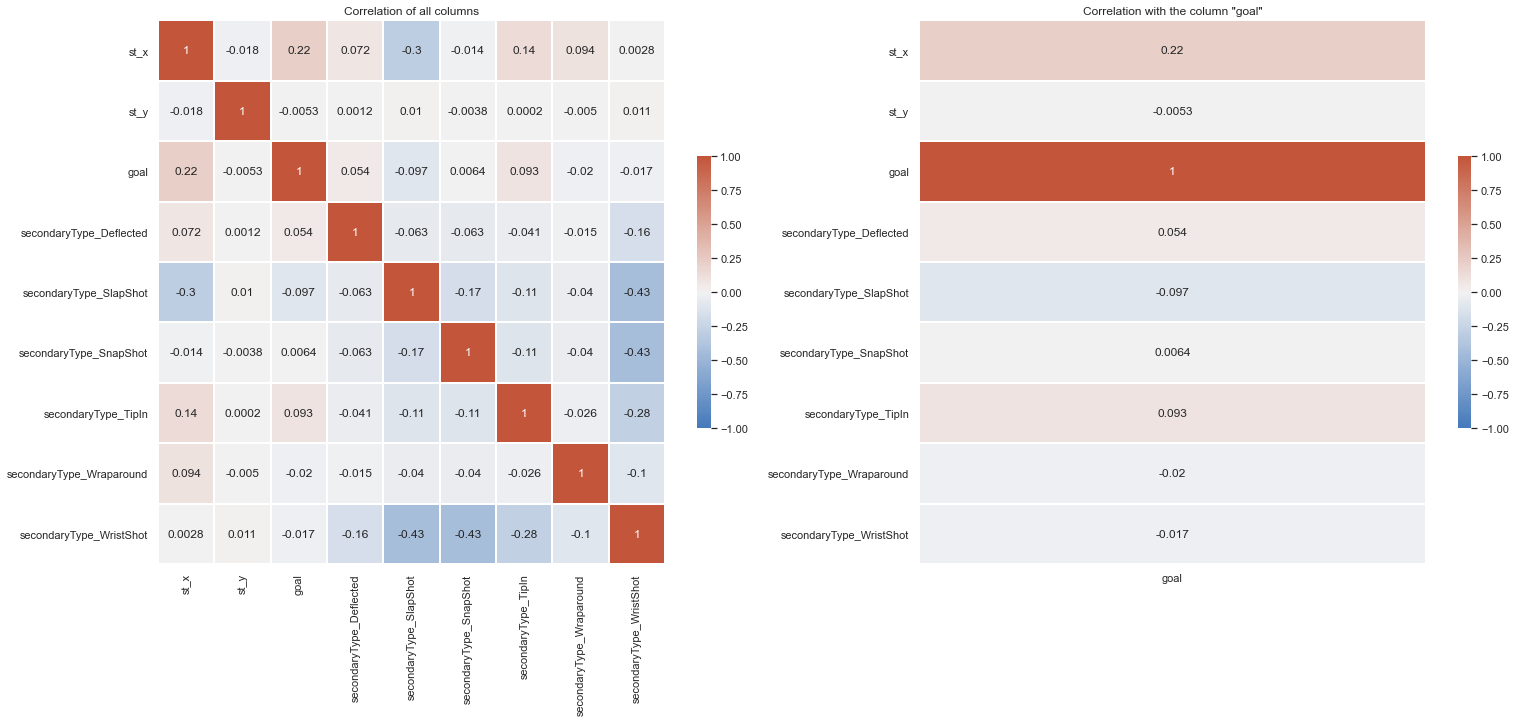

In [15]:
corr = df_data.corr()
cmap = sns.diverging_palette(250, 20, as_cmap=True)

plt.subplots(1, 2, figsize=(25, 10))
plt.subplot(121)
plt.title(f'Correlation of all columns')
sns.heatmap(corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});

plt.subplot(122)
col='goal'
plt.title(f'Correlation with the column "{col}"')
sns.heatmap(corr[[col]], cmap=cmap, vmin=-1, vmax=1, center=0, annot=True, linewidths=1, cbar_kws={"shrink": .5});


The highest correlation with the column goal has *st_x*. This might be an indicator of the most important feature but in most cases, the combination of different features makes it.
___
Let's try to use this feature only for the prediction: 

In [16]:
# use just the most correlated feature
features = ['st_x']
target = 'goal'

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data[features], df_data[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.4f}')

#f1 score
print(f'F1-Score of the model is {f1_score(y_test, lr_model.predict(X_test)):.4f}')

Score of the model is 0.6311
F1-Score of the model is 0.6642


---
We achieved slightly higher F1 score but still not really what we need. The feature *st_x* might be an indicator for possibly even more interesting feature, which if the **distance** to the goal. Let's model it in the next section.

## Engineering distance as predictive feature

In the first step, we can visualize some data to get a good intuition how to calculate the distance from *st_x* and *st_y*.

(-60.0, 60.0)

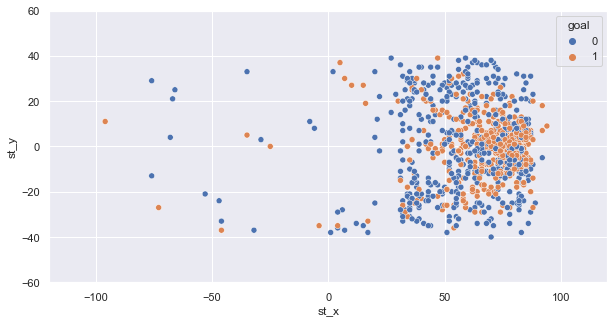

In [17]:
# plotting sample from the dataset

df_data_sample = df_data.sample(n=1000, replace=True)
# scatter plot
plt.figure(figsize=(10,5))
sns.scatterplot(data=df_data_sample, x='st_x', y='st_y',hue='goal')
plt.xlim(-120, 120)
plt.ylim(-60, 60)

In [18]:
#visualize 3 shots to understand the coordinates system
df_data[:3]

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0
96,2016020045_97,76.0,-1.0,1,0,0,0,0,0,0
102,2016020045_103,67.0,28.0,1,0,1,0,0,0,0


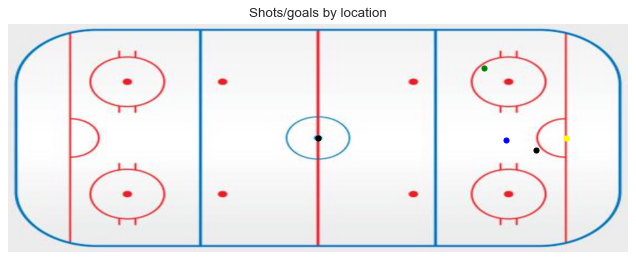

In [19]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
#plt.scatter(df_data[:2].st_x, df_data[:2].st_y, s=20, c='black');
plt.scatter([0], [0], s=20, c='black');
plt.scatter([88], [-5], s=20, c='black');
plt.scatter([76], [-1], s=20, c='blue');
plt.scatter([67], [28], s=20, c='green');
plt.scatter([100], [0], s=20, c='yellow');

plt.title('Shots/goals by location');

Middle of the field is [0, 0]. Middle of the goal is [100, 0]. Using method *math.hypot*, I can calculate the distance between two points.

In [20]:
middle_goal_x = 100 
middle_goal_y = 0

In [21]:
# distance from the middle of the field
math.hypot(middle_goal_x - 0, middle_goal_y - 0)

100.0

In [22]:
# distance from the black dot [88, -5]
math.hypot(middle_goal_x - 88, middle_goal_y - (-5))

13.0

In [23]:
# distance from the blue dot [76, -1]
math.hypot(middle_goal_x - 76, middle_goal_y - (-1))

24.020824298928627

In [24]:
# distance from the green dot [67, 28]
math.hypot(middle_goal_x - 67, middle_goal_y - 28)

43.278170016764804

It looks like the calculation makes sense. The black dot is the closest one, the blue dot is middle one and the distance of the green dot to the goal (yellow dot) is biggest.

---
Let's apply it for all shots and introduce a new column *distance*:

In [25]:
def dist(df): 
    middle_goal_x = 100 
    middle_goal_y = 0
    return math.hypot(middle_goal_x - df.st_x, middle_goal_y - df.st_y)

df_data_dist = df_data.copy()
df_data_dist['distance'] = df_data_dist.apply(dist, axis=1)
df_data_dist.head()

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0,13.000000
96,2016020045_97,76.0,-1.0,1,0,0,0,0,0,0,24.020824
102,2016020045_103,67.0,28.0,1,0,1,0,0,0,0,43.278170
139,2016020045_140,83.0,-11.0,1,0,0,0,0,0,0,20.248457
196,2016020045_197,76.0,11.0,1,0,0,0,0,0,1,26.400758


### Using distance as predictive feature

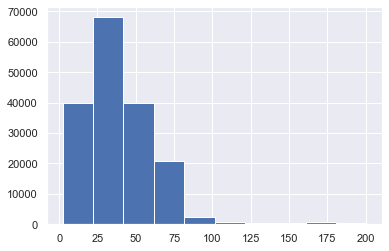

In [26]:
df_data_dist.distance.hist();

Cutting off outliers:

In [27]:
df_data_dist = df_data_dist[df_data_dist.distance<100]

---
Let's see if and how the correlation has changed after we introduced the new feature:

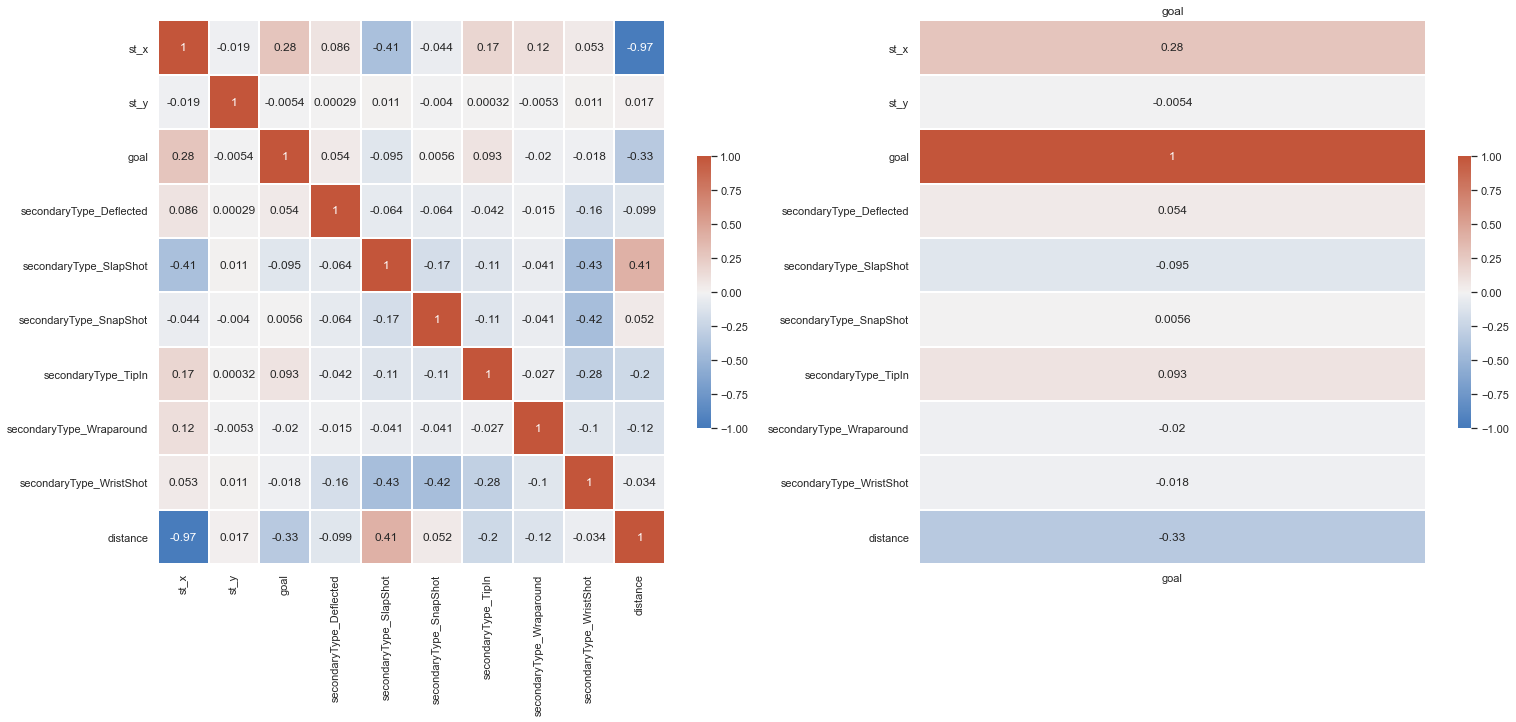

In [28]:
# using function plot_correlation_matrix from util.py to re-use code:
plt.subplots(1, 2, figsize=(25, 10))
plt.subplot(121)
plot_correlation_matrix(df_data_dist)

plt.subplot(122)
plot_correlation_matrix(df_data_dist, col='goal')

Distance looks to be pretty correlated with goal. It's the most correlated column with the *goal* so far.

---
Using all features to predict the goal now:

In [29]:
features = ['st_x', 'st_y', 'secondaryType_Deflected', 'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound', 'secondaryType_WristShot', 'distance']
target = 'goal'

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data_dist[features], df_data_dist[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.4f}')

#f1 score
print(f'F1-Score of the model is {f1_score(y_test, lr_model.predict(X_test)):.4f}')

Score of the model is 0.6728
F1-Score of the model is 0.6905


This is a significant improvement. The F1 score has been increased from 0.66 to 0.69. 

---
Before we continue, let's visualize what is actually the F1 score actually worth. 

## Visual evaluation of the model

Logistic Regression predicts the probability of every outcome to be *0* or *1*. A threshold is defined (default 0.5) to decide, when is a particular outcome to be classified as *0* and when as *1*. In order to do this, logistic regression uses the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).

$$ S(y) = \frac{1}{1+e^{-y}} $$

Let's consider a logistic regression model using just one predictive feature, which is the **distance** to the goal. The sigmoid function is 
<br>
<br>
$$ S(y) = \frac{1}{1+e^{-(\Theta _{1}*x_{1}+\Theta _{0}))}} = \frac{1}{1+e^{-(coef * distance+interpect)}} $$ 
<br>
<br>
where coef and interpect can be extracted from the lr_model. Having the values of **coef** and **intercept**, we can visualize the sigmoid function generated by the logistic regression model and see, how this function fits data points from the dataset

---
Let's get this parameters:

In [30]:
# distance as only predictive feature
features = ['distance']
target = 'goal'


#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data_dist[features], df_data_dist[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.4f}')

#f1 score
print(f'F1-Score of the model is {f1_score(y_test, lr_model.predict(X_test)):.4f}')

coef = lr_model.coef_
intercept = lr_model.intercept_

print('-------------------------------------')
print(f'Coef of the model is {coef}')
print(f'Intercept of the model is {intercept}')

Score of the model is 0.6497
F1-Score of the model is 0.6712
-------------------------------------
Coef of the model is [[-0.04164299]]
Intercept of the model is [1.56945262]


---
Let's make the visualization of how the sigmoid function fits data points from the dataset:

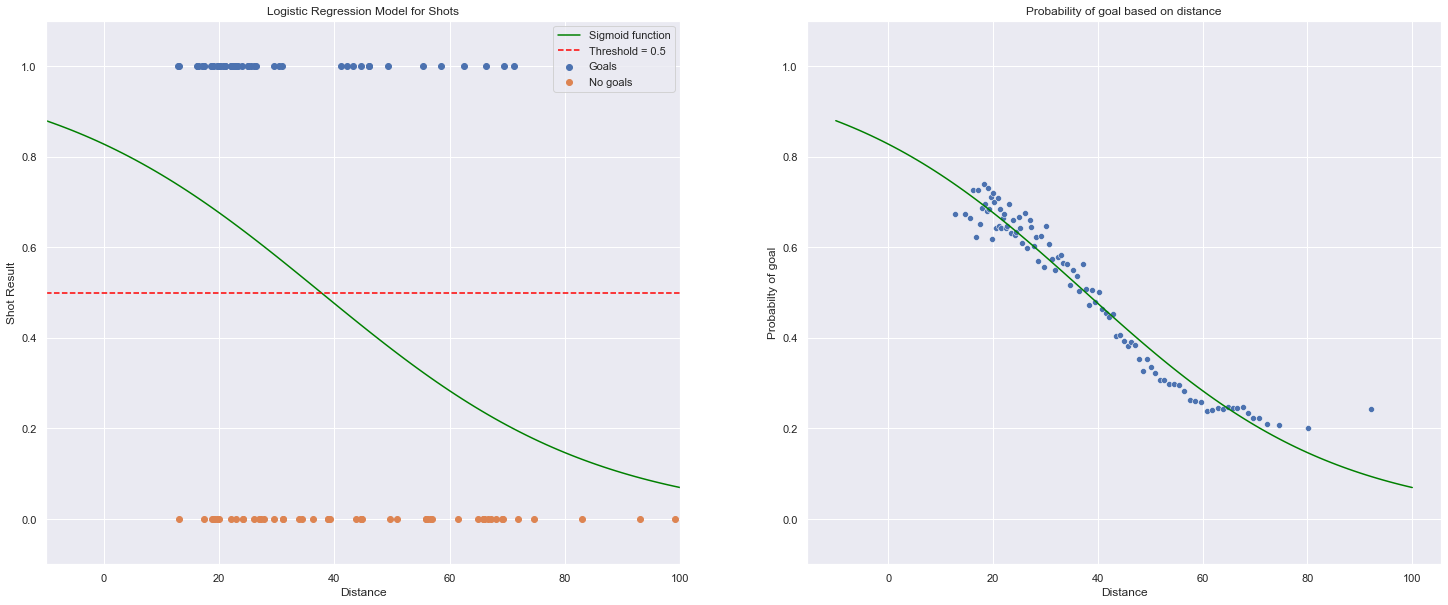

In [31]:
#############################################
# On the lef side of the plot, we visualize 0/1 targets of the dataset
df_goals = df_data_dist[df_data_dist.goal==1]
df_no_goals = df_data_dist[df_data_dist.goal==0]

fig, ax = plt.subplots(1, 1, figsize=(25, 10))
plt.subplot(121)
plt.scatter(df_goals.distance.head(50),df_goals.goal.head(50), label='Goals')
plt.scatter(df_no_goals.distance.head(50),df_no_goals.goal.head(50), label='No goals')
y = np.linspace(-10,100,100)
plt.plot(y,1/(1+np.exp(-(lr_model.coef_[0][0]*y+lr_model.intercept_[0]))),c='Green', label='Sigmoid function')

plt.xlabel('Distance')
plt.ylabel('Shot Result')
plt.title('Logistic Regression Model for Shots')
plt.axhline(y=0.5, color='red', linestyle='dashed',label='Threshold = 0.5')
plt.legend()

plt.xlim(-10, 100);
plt.ylim(-.1, 1.1);

#############################################
# On the right side of the plot, we visualize real probability of a shot beign a goal and compare to predicticted sigmoid function.
# This will show us how the model fits the data points of the dataset.
df = df_data_dist.copy()
# As we have no probability of every single shot in the dataset, we bin shots/distances and see how many of them landed as a goal (mean of goal)
df['distbins'] = pd.qcut(df.distance,q=100)
# Calculate the mean of goal column(prob density) for each bin and mean of the distance for each bin
distprob = df.groupby('distbins',as_index=False)['goal'].mean()['goal']
distmean = df.groupby('distbins',as_index=False)['distance'].mean()['distance']

# Plotting probabilty of the goal per distance as scatter plot  
plt.subplot(122)
dist_trend = sns.scatterplot(x=distmean,y=distprob)
dist_trend.set(xlabel="Distance", ylabel="Probabilty of goal", title="Probability of goal based on distance")

# Now plotting the same sigmoid function like on the left side
y = np.linspace(-10,100,100)

plt.plot(y,1/(1+np.exp(-(lr_model.coef_[0][0]*y+lr_model.intercept_[0]))),c='Green',label='Logistic Model')
plt.ylim(-.1, 1.1)
plt.show()



### Conclusion on the visual evaluation:
Even if using a sigle feature (distance) to predict the goal achieves the F1 Score of **0.68** only, the sigmoid function (right plot) **fits pretty good** the probability of scoring a goal from the dataset. This value can be **used as benchmark** in next attempts to improve the model in the following sections.

---

## Engineering angle as predictive feature

Similar to the distance feature, lets create a feature for the angle of the shot. 

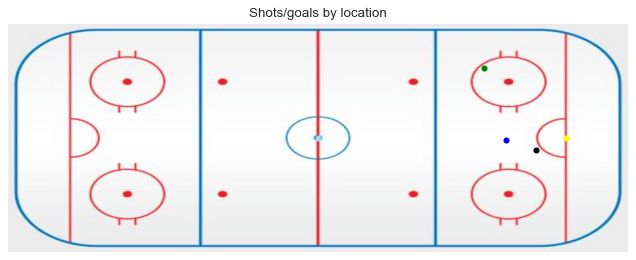

In [32]:
plt.figure(figsize=(10, 6), dpi=80)
img=plt.imread('data/images/rink.jpg')
plt.grid()
plt.axis("off")
plt.imshow(img, extent=[-125, 125, -46, 46])
#plt.scatter(df_data[:2].st_x, df_data[:2].st_y, s=20, c='black');
plt.scatter([0], [0], s=20, c='lightblue');
plt.scatter([88], [-5], s=20, c='black');
plt.scatter([76], [-1], s=20, c='blue');
plt.scatter([67], [28], s=20, c='green');
plt.scatter([100], [0], s=20, c='yellow');

plt.title('Shots/goals by location');

First we need to place the middle of the coordinates to the middle of the goal: 'y = y', 'x = x-100' <br>
The line from the middle of the goal to the middle of the field should be 0 degree. <br>
Using ata2, we need to convert to dergees and add 90 degrees to recalibrate to the middle of the field.

In [33]:
# try on the lightblue dot, middle of the field (0, 0)
math.degrees(math.atan2(-100, 0)) + 90

0.0

In [34]:
# try on the black dot (88, -5)
math.degrees(math.atan2(-12, -5)) + 90

-22.61986494804043

In [35]:
# try on the blue dot (76, -1)
math.degrees(math.atan2(-24, -1)) + 90

-2.3859440303888277

In [36]:
# try on the green dot (67, 28)
math.degrees(math.atan2(-33, 28)) + 90

40.3141001604973

This looks like the angles make sense. Let's add it to the dataframe

In [37]:
def angle(df):     
    middle_goal_x = 100 
    return math.fabs(math.degrees(math.atan2(df.st_x - middle_goal_x, df.st_y)) + 90)

df_data_dist_angle = df_data_dist.copy()
df_data_dist_angle['angle'] = df_data_dist_angle.apply(angle, axis=1)
df_data_dist_angle.head()

,play_id,st_x,st_y,goal,secondaryType_Deflected,secondaryType_SlapShot,secondaryType_SnapShot,secondaryType_TipIn,secondaryType_Wraparound,secondaryType_WristShot,distance,angle
5,2016020045_6,88.0,-5.0,1,0,0,0,0,1,0,13.000000,22.619865
96,2016020045_97,76.0,-1.0,1,0,0,0,0,0,0,24.020824,2.385944
102,2016020045_103,67.0,28.0,1,0,1,0,0,0,0,43.278170,40.314100
139,2016020045_140,83.0,-11.0,1,0,0,0,0,0,0,20.248457,32.905243
196,2016020045_197,76.0,11.0,1,0,0,0,0,0,1,26.400758,24.623565


### Using angle in the model

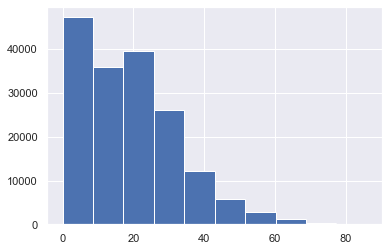

In [38]:
df_data_dist_angle.angle.hist();

In [39]:
# cutting off outliers:
df_data_dist_angle = df_data_dist_angle[df_data_dist_angle.angle<70]

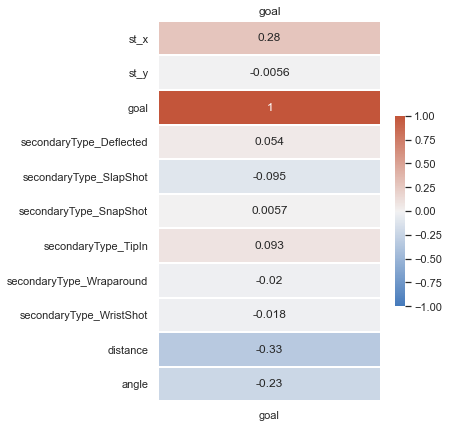

In [40]:
plt.subplots(1, 1, figsize=(5, 7))
plot_correlation_matrix(df_data_dist_angle, col='goal')

The feature **angle** doesn't look to be very correlated to the **goal**, let's add it anyway and see the impact on the f1-score.

---



In [41]:
features = ['st_x', 'st_y', 'secondaryType_Deflected', 'secondaryType_SlapShot', 'secondaryType_SnapShot',
        'secondaryType_TipIn', 'secondaryType_Wraparound', 'secondaryType_WristShot', 'distance', 'angle']
target = 'goal'


#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_data_dist_angle[features], df_data_dist_angle[target], test_size=0.3, random_state=42)

# create model
lr_model = LogisticRegression(max_iter=10000);

#fit model
lr_model.fit(X_train,y_train)

# score
print(f'Score of the model is {lr_model.score(X_test, y_test):.4f}')

#f1 score
print(f'F1-Score of the model is {f1_score(y_test, lr_model.predict(X_test)):.4f}')

Score of the model is 0.6752
F1-Score of the model is 0.6888


---
The impact of the feature **angle** is extremely low. This means that **distance** is much more important in predicting the scoring of the goal than the angle. 


---

## Selecting classifier

After some first feature engineering and increasing of the model F1 Score from 0.66 to 0.70, we have enough features to make some experiments with different classifiers. I will consider:
* [Logistic Regression Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) (this has been used already in previous sections)
* [K-Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
* [LightGMB Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

